# Project Status

Our focus has been developing a reliable Allan Deviation method. The currently available, open source projects for calculating the Allan Deviation did not meet the quality of `allanvar` in MATLAB. So, we wrote our own overlapping Allan Deviation function that matches the performance of MATLAB.

Our custom built method was used to generate Allan Deviations for several datasets:  
- `LoggedSingleAxisGyro` - *MATLAB gyroscope example data*
- `Coupled Accelerometer Data Closed Loop` - *Accelerometer Data collected by Dr. Ying Lia Li. Shortened to "Lia 2017".*  
~~- `imu6` - *IMU datasets from SMAC Group*~~

*Note:  `navchip` or `ln200.gyro` would be better options to test from SMAC*

The `LoadedSingleAxisGyro` dataset is the dataset used in the Allan variance example from MathWorks. The Allan Deviation plot generated by our custom function is identical to that shown in the MathWorks example, as expected.

Allan deviation plots for `lia_2017` were created using `allanvar` in MATLAB, so it made sense to use our custom function on this dataset and compare the results. Again, the plots are identical. 

*Note:  Link or add plots from both sources for each dataset*

Finally, the SMAC data was analysed. Since the data was collected by a group outside of our own project and independent of MathWorks, testing the custom function on this dataset is a way of checking that the function can perform on IMU data in the wild.

# Introduction

Going forward, the custom overlapping Allan deviation function will be how we calculate Allan deviations (unless otherwise noted).

The point of this notebook is to explore the effects of filters on the resulting Allan deviation. The experiment(s) will generally go as follows:

1. Apply a single filter to the raw time series (values from the IMU accelerometer/gyro)
2. Calculate the Allan deviation of the filtered signal
3. Compare the result to the unfiltered signal
4. Repeat for different filters

To get started, we'll explore the effect of filtering on `LoggedSingleAxisGyro`.

# Preamble

The following files need to be manually uploaded to run the notebook:
- `LoggedSingleAxisGyroscope.csv`
- `allan_variance.py`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq, fft
from allan_variance import overlapping_allan_deviation, plot_allan_deviation

# Unfiltered Allan Deviation

In this section, we read in the gyroscope data and create an Allan deviation plot

In [2]:
#path to `LoggedSingleAxisGyroscope.csv`
single_axis_gyro_path = "/content/LoggedSingleAxisGyroscope.csv"

In [3]:
#column names
names = ["Data"]
#read in gyroscope data
sa_df = pd.read_csv(single_axis_gyro_path, names=names)

In [4]:
#preview dataframe
sa_df.head()

,Data
0,0.14875
1,-0.05250
2,-0.04375
3,0.17500
4,-0.05250


In [5]:
#convert data into numpy array
single_axis_data = sa_df.to_numpy()

In [6]:
#sampling rate (Hz)
Fs = 100 

#calculate overlapping Allan deviation
taus, oadev = overlapping_allan_deviation(single_axis_data, Fs=Fs)

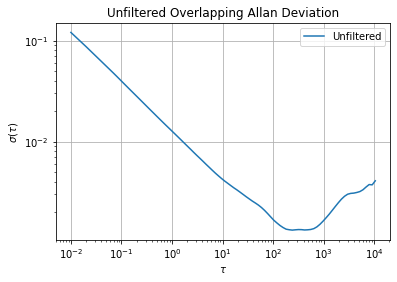

In [7]:
#plot the result
plot_allan_deviation(taus, oadev, "Unfiltered", "Unfiltered Overlapping Allan Deviation")

In [8]:
def compare_std(data, oadev):
    """
    Compare the starting Allan deviation and standard deviation of the data.
    The starting Allan deviation and the standard deviation of the data should
    be the same.

    Args:
    data (numpy array) - Time series of gyroscope (accelerometer) readings
    oadev (numpy array) - Column vector of overlapping Allan deviation values. Shape (_, 1)

    Returns:
    (tuple) - Values of standard deviation, overlapping Allan deviation, and 
                percent difference between the two values.
    """

    #standard deviation of the data
    std = np.std(data)
    #starting Allan deviation 
    allan_std = oadev[0][0]
    #percent difference
    pct = (allan_std-std)/std

    #verbose
    print(f"Dataset Standard Deviation {std:0.5f}")
    print(f"Start of Allan Deviation {allan_std:0.5f}")
    print(f"Percent Difference {pct*100:0.5f}%")

    return (std, allan_std, pct*100)

In [9]:
compare_std(single_axis_data, oadev)

Dataset Standard Deviation 0.12231
Start of Allan Deviation 0.12030
Percent Difference -1.64236%


(0.12231351228376397, 0.12030467991756107, -1.6423634058863976)

# Filtering White Noise

We need to determine the specifications of the filter, before we can build it. These sepecifications can be the order of the filter or the cutoff frequency of the pass band, for example.

To get an idea for the cutoff frequency, it's useful to look at the power spectral density (PSD) of the signal. The PSD is a density plot showing how the power of the signal is distributed across a frequency spectrum.

## PSD of Signal

In [10]:
def power_spectral_density(data, dt):

    """
    Plot the power spectral density and data time series as subplots of a single figure.
    
    Args:
    data (numpy array) - Time series data
    dt (float) - Sampling period
    """

    n = len(data)
    f = data.reshape(-1, )
    fhat = rfft(f, n)
    PSD = fhat * np.conj(fhat) / n
    freq = (1/(dt*n)) * np.arange(len(PSD))
    L = np.arange(1, np.floor(n/2), dtype=int)

    fig, ax = plt.subplots(2,1)

    plt.sca(ax[0])
    plt.plot(data)
    plt.xlabel("Time (s)")
    plt.ylabel("Raw Data")


    plt.sca(ax[1])
    plt.plot(freq[L], PSD[L])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Magnitude")

    plt.show()

    return 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


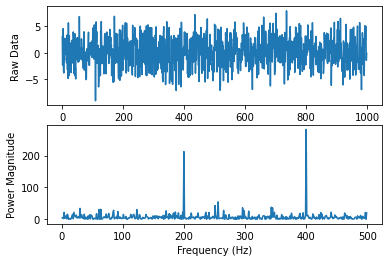

In [11]:
#test power spectral density function with a toy example
dt = 0.001
t = np.arange(0, 1, dt)
freq1 = 400
freq2 = 200
f = np.sin(2*np.pi*freq1*t) + np.sin(2*np.pi*freq2*t)
f_clean = f
f = f + 2.5*np.random.randn(len(t))
power_spectral_density(f, dt)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


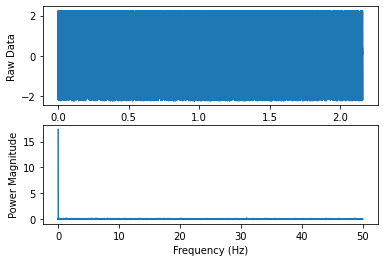

In [12]:
power_spectral_density(single_axis_data, 1/100)

In [13]:
coupled_path = "/content/Coupled_1_firsthalf.csv"
coupled_data = pd.read_csv(coupled_path, names=["Sensor", "Laser"])

In [14]:
coupled_data.head()

,Sensor,Laser
0,13796,26240
1,13900,26332
2,13812,26284
3,13848,26260
4,13828,26308


In [15]:
sensor = coupled_data["Sensor"]
laser = coupled_data["Laser"]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


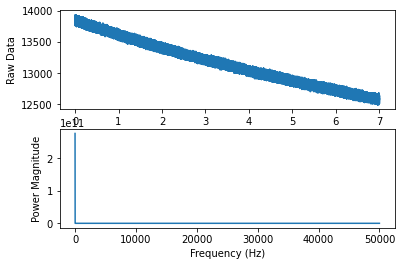

In [16]:
power_spectral_density(sensor.to_numpy(), 10e-6)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


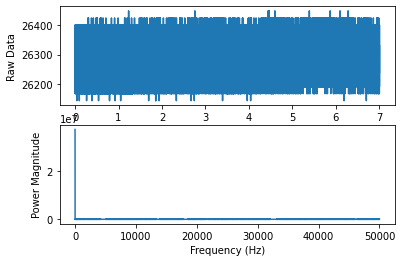

In [17]:
power_spectral_density(laser.to_numpy(), 10e-6)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


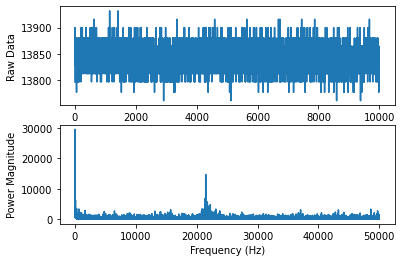

In [18]:
sensor_sample = sensor[:10000]
power_spectral_density(sensor_sample.to_numpy(), 10e-6)

In [21]:
chunksize = 10_000
for i in range(0, len(single_axis_data), chunksize):
    f = single_axis_data[i:i+chunksize]
    power_spectral_density(f, 100)

Output hidden; open in https://colab.research.google.com to view.

In [34]:
from scipy.signal import butter, lfilter, freqz

In [35]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype="lowpass", analog=False)
    return b, a

In [36]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff=cutoff, fs=fs, order=order)
    y = lfilter(b, a, data)
    return y

In [92]:
y = butter_lowpass_filter(single_axis_data, 0.002, 100, order=3)

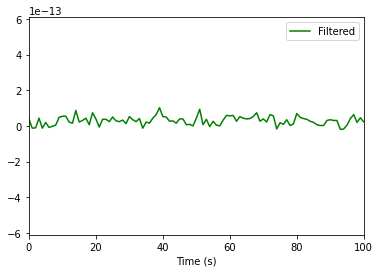

In [93]:
#plt.plot(single_axis_data, "b-", label="Unfiltered")
plt.plot(y, "g-", label="Filtered")
plt.xlim(0, 100)
plt.xlabel("Time (s)")
plt.legend(loc="upper right")
plt.show()

(0.0, 100.0)

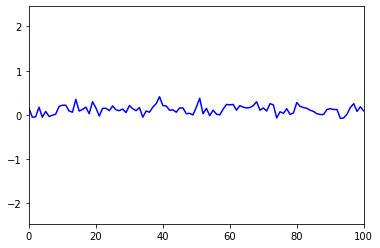

In [75]:
plt.plot(single_axis_data, "b-", label="Unfiltered")
plt.xlim(0, 100)

In [83]:
dt = 0.001
t = np.arange(0, 1, dt)
freq1 = 50
freq2 = 120
f = np.sin(2*np.pi*freq1*t) + np.sin(2*np.pi*freq2*t)
f_clean = f
f = f + 2.5*np.random.randn(len(t))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


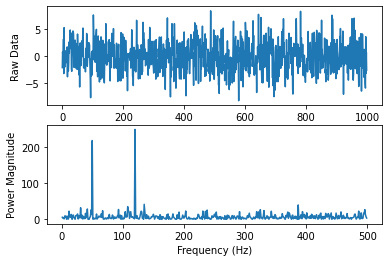

In [84]:
power_spectral_density(f, dt=dt)

In [96]:
y = butter_lowpass_filter(f, 120, 1/dt, order=5)

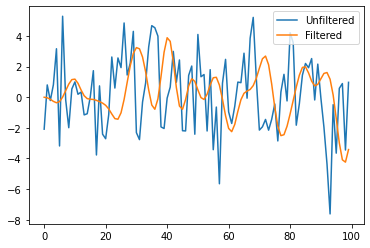

In [97]:
plt.plot(f[:100], label="Unfiltered")
plt.plot(y[:100], label="Filtered")
plt.legend(loc="upper right")